# TensorFlow Distributions as Cost Functions

Sometimes you want to fit a function were your standard mean square error or mean absolute error doesn't not do a great job. Sometimes you want to find parameters to probability distribution. Here I show how you could do that.

In [1]:
import numpy as np
import scipy.stats as stats

import statsmodels.api as sm

import keras
import keras.backend as K
import keras.optimizers as kopt
from keras.models import Model
from keras.layers import Input, Dense, concatenate

import tensorflow.contrib.distributions as tfdist

from sklearn.metrics import r2_score, mean_squared_error

from rosey.keras_utils import keras_r2

import matplotlib.pyplot as graph
import seaborn as sns

graph.style.use('fivethirtyeight')

/home/stephen/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/stephen/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


Rsq = 0.558
MSE = 7.780
Mean loglikelihood = -2.4497965129009436


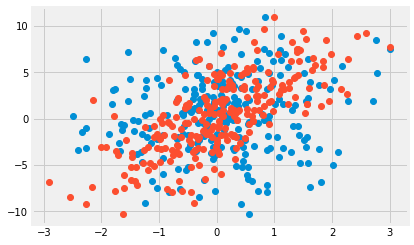

In [2]:
n = 250
m, ep = np.array([1, 3]), 3

x = stats.norm(0, 1).rvs(size=(n, 2))
y = x @ m + stats.norm(0, ep).rvs(size=n)

print(f'Rsq = {r2_score(y, x @ m):0.3f}')
print(f'MSE = {mean_squared_error(y, x @ m):0.3f}')
print(f'Mean loglikelihood = {stats.norm(x @ m, ep).logpdf(y).mean()}')

graph.plot(x, y, 'o')
graph.show()

In [3]:
print(y.mean(), y.std())
print(stats.norm(y.mean(), y.std()).logpdf(y).mean())

0.408343593549797 4.196660909092196
-2.853227720651972


# Statsmodels

In [4]:
glm = sm.GLM(y, x).fit()
display(glm.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                            GLM   Df Residuals:                      248
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:               7.810402211331509
Method:                          IRLS   Log-Likelihood:                -610.66
Date:                Tue, 24 Jul 2018   Deviance:                       1937.0
Time:                        15:02:50   Pearson chi2:                 1.94e+03
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8828      0.175      5.057      0.000       0.541       1.225
x2             3.1216      0.177     17.650      0.000       2.775       3.468
==============================================================================
"""

# Keras OLS Regression

Learning the conditional mean given data.

In [5]:
input_layer = Input(shape=(x.shape[1],))

In [6]:
# Keras OLS
ols_layer = Dense(1, kernel_initializer='zeros')(input_layer)
ols_model = Model(input_layer, ols_layer)

print(ols_model.summary())

# Fit OLS model
ols_model.compile(loss='mse', metrics=[keras_r2], optimizer=kopt.SGD(0.01))
ols_model.fit(
    x, y, 
    epochs=100, verbose=1, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)]
)

print(ols_model.layers[1].get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
250/250 [==============================] - 0s 283us/step - loss: 16.5699 - keras_r2: 0.0285
Epoch 2/100
250/250 [==============================] - 0s 63us/step - loss: 14.1769 - keras_r2: 0.1661
Epoch 3/100
250/250 [==============================] - 0s 46us/step - loss: 12.4672 - keras_r2: 0.2681
Epoch 4/100
250/250 [==============================] - 0s 51us/step - loss: 11.2100 - keras_r2: 0.3379
Epoch 5/100
250/250 [==============================] - 0s 38us/step - loss: 10.2817 - keras_r2: 0.3961
Epoch 6/100
250/250 [==

# Keras Distribution as Loss Function

Here I fit a linear model where the loss function is a the mean negative log likelihood of observing `y_true` given proposed model parameters.

I am using the **mean** rather than the **sum** of the negative log likelihood because it is has identical optima while being invariant to batch size.

Finding the optimal value for likelihood functions are famously hard so I use stochastic gradient descent with a learning rate drop off. Needless to say, it takes a lot longer to converge.

In [7]:
def normal_loglikelihood(y_true, parameters):
    m, s = parameters[:, 0], parameters[:, 1]
    m, s = K.expand_dims(m), K.expand_dims(s)
    
    norm = tfdist.Normal(m, s)
    return K.mean(-norm.log_prob(y_true))

In [8]:
mu = Dense(1, kernel_initializer='zeros')(input_layer)
sigma = Dense(1, kernel_initializer='zeros', activation='softplus')(input_layer)

params = concatenate([mu, sigma])

linear_model = Model(input_layer, params)

print(linear_model.summary())

# Fit sigma conditional model
linear_model.compile(loss=normal_loglikelihood, optimizer=kopt.SGD(0.01))
hist = linear_model.fit(
    x, y, 
    epochs=5000, verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='loss', patience=10),
        keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1),
        keras.callbacks.ModelCheckpoint('temp', monitor='loss', save_best_only=True)
    ]
)

# Check coefficents
print(linear_model.layers[1].get_weights())
print(linear_model.layers[2].get_weights())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            3           input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            3           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           dense_2[0][0]                    
                                                                 dense_3[0][0]                    
Total para

250/250 [==============================] - 0s 48us/step - loss: 2.5130
Epoch 80/5000
250/250 [==============================] - 0s 43us/step - loss: 2.5115
Epoch 81/5000
250/250 [==============================] - 0s 39us/step - loss: 2.5101
Epoch 82/5000
250/250 [==============================] - 0s 44us/step - loss: 2.5088
Epoch 83/5000
250/250 [==============================] - 0s 54us/step - loss: 2.5073
Epoch 84/5000
250/250 [==============================] - 0s 63us/step - loss: 2.5060
Epoch 85/5000
250/250 [==============================] - 0s 53us/step - loss: 2.5047
Epoch 86/5000
250/250 [==============================] - 0s 57us/step - loss: 2.5034
Epoch 87/5000
250/250 [==============================] - 0s 65us/step - loss: 2.5021
Epoch 88/5000
250/250 [==============================] - 0s 63us/step - loss: 2.5008
Epoch 89/5000
250/250 [==============================] - 0s 69us/step - loss: 2.4997
Epoch 90/5000
250/250 [==============================] - 0s 69us/step - loss: 2

250/250 [==============================] - 0s 50us/step - loss: 2.4415
Epoch 175/5000
250/250 [==============================] - 0s 50us/step - loss: 2.4412
Epoch 176/5000
250/250 [==============================] - 0s 57us/step - loss: 2.4409
Epoch 177/5000
250/250 [==============================] - 0s 64us/step - loss: 2.4406
Epoch 178/5000
250/250 [==============================] - 0s 59us/step - loss: 2.4403
Epoch 179/5000
250/250 [==============================] - 0s 66us/step - loss: 2.4400
Epoch 180/5000
250/250 [==============================] - 0s 67us/step - loss: 2.4396
Epoch 181/5000
250/250 [==============================] - 0s 67us/step - loss: 2.4393
Epoch 182/5000
250/250 [==============================] - 0s 66us/step - loss: 2.4390
Epoch 183/5000
250/250 [==============================] - 0s 62us/step - loss: 2.4387
Epoch 184/5000
250/250 [==============================] - 0s 74us/step - loss: 2.4385
Epoch 185/5000
250/250 [==============================] - 0s 64us/ste

250/250 [==============================] - 0s 37us/step - loss: 2.4260
Epoch 270/5000
250/250 [==============================] - 0s 48us/step - loss: 2.4260
Epoch 271/5000
250/250 [==============================] - 0s 37us/step - loss: 2.4260
Epoch 272/5000
250/250 [==============================] - 0s 48us/step - loss: 2.4258
Epoch 273/5000
250/250 [==============================] - 0s 68us/step - loss: 2.4258
Epoch 274/5000
250/250 [==============================] - 0s 67us/step - loss: 2.4258
Epoch 275/5000
250/250 [==============================] - 0s 52us/step - loss: 2.4257
Epoch 276/5000
250/250 [==============================] - 0s 43us/step - loss: 2.4256
Epoch 277/5000
250/250 [==============================] - 0s 61us/step - loss: 2.4256
Epoch 278/5000
250/250 [==============================] - 0s 45us/step - loss: 2.4256
Epoch 279/5000
250/250 [==============================] - 0s 44us/step - loss: 2.4255
Epoch 280/5000
250/250 [==============================] - 0s 47us/ste

250/250 [==============================] - 0s 53us/step - loss: 2.4243

Epoch 00350: ReduceLROnPlateau reducing learning rate to 1.5258788721439487e-07.
Epoch 351/5000
250/250 [==============================] - 0s 57us/step - loss: 2.4243
Epoch 352/5000
250/250 [==============================] - 0s 53us/step - loss: 2.4243
Epoch 353/5000
250/250 [==============================] - 0s 43us/step - loss: 2.4243

Epoch 00353: ReduceLROnPlateau reducing learning rate to 7.629394360719743e-08.
Epoch 354/5000
250/250 [==============================] - 0s 56us/step - loss: 2.4243
Epoch 355/5000
250/250 [==============================] - 0s 51us/step - loss: 2.4243
Epoch 356/5000
250/250 [==============================] - 0s 72us/step - loss: 2.4243

Epoch 00356: ReduceLROnPlateau reducing learning rate to 3.814697180359872e-08.
Epoch 357/5000
250/250 [==============================] - 0s 64us/step - loss: 2.4243
Epoch 358/5000
250/250 [==============================] - 0s 60us/step - loss: 2.42

# Comparsion

Check the results from a single point.

[[1. 4.]]
(1, 2)

True value y     = [[13.]]
OLS value E(y)   = [[13.440549]]
y|x ~ N(mu, sig) = [[12.937145  2.659118]]


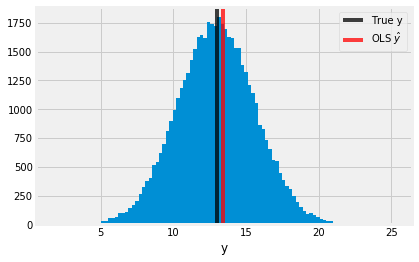

In [9]:
query = np.asmatrix([1, 4], dtype=np.float)
print(query)
print(query.shape)
print()

print('True value y     =', query @ m)
print('OLS value E(y)   =', ols_model.predict(query))
print('y|x ~ N(mu, sig) =', linear_model.predict(query))

lm_y_params = linear_model.predict(query)[0]

graph.hist(stats.norm(*lm_y_params).rvs(50000), bins=100, label='')
graph.axvline(query @ m, color='black', alpha=0.75, label='True y')
graph.axvline(ols_model.predict(query)[0], color='red', alpha=0.75, label=r'OLS $\hat{y}$')
graph.xlabel('y')
graph.legend()
graph.show()

_Stephen Anthony Rose_